<a href="https://colab.research.google.com/github/ankkod/HateSpeechDetection/blob/main/HateSpeechClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Transformers installation
! pip install transformers

     |████████████████████████████████| 2.9 MB 5.0 MB/s 
     |████████████████████████████████| 895 kB 49.2 MB/s 
     |████████████████████████████████| 3.3 MB 43.8 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 596 kB 45.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import re

import nltk
from nltk.corpus import stopwords 

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Temp/labeled_data.csv')

In [ ]:
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
data['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

In [ ]:
data = data.drop(data[data['class'] == 1].sample(17190).index)
data = data.drop(data[data['class'] == 2].sample(2163).index)
# data = data.drop(data[data['class'] == 0].sample(430).index)

In [ ]:
data['class'].value_counts()

2    2000
1    2000
0    1430
Name: class, dtype: int64

Three different classes:


    0 - hate speech 
    1 - offensive language 
    2 - neither



In [ ]:
data.isnull().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [ ]:
data.isna().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [ ]:
# Dropping other columns
data.drop(columns=['count', 'hate_speech', 'offensive_language', 'neither', 'Unnamed: 0'], inplace=True)

# Preprocessing

In [ ]:
# Remove Stopwords
# from nltk.corpus import stopwords
# import nltk
# nltk.download('stopwords')
# from nltk.tokenize.toktok import ToktokTokenizer

# tokenizer = ToktokTokenizer()
# stopword_list = nltk.corpus.stopwords.words('english')

# def remove_stopwords(text, is_lower_case=False):
#   tokens = tokenizer.tokenize(text)
#   tokens = [token.strip() for token in tokens]
#   if is_lower_case:
#       filtered_tokens = [token for token in tokens if token not in stopword_list]
#   else:
#       filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
#   filtered_text = ' '.join(filtered_tokens)    
#   return filtered_text

# df = data.copy()
# data['tweet'] = data['tweet'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
21,1,""" cancel that bitch like Nino """
24,1,""" got ya bitch tip toeing on my hardwood floor..."
28,1,""" i need a trippy bitch who fuck on Hennessy """
33,1,""" if you're toes ain't done you pussy stinks """


In [ ]:
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

In [ ]:
labels = data['class'].to_list()
texts = data['tweet'].to_list()

In [ ]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=.2)

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# from transformers import AutoTokenizer
# checkpoint = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
## TENSORFLOW CODE
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    np.asarray(train_labels)
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    np.asarray(test_labels)
))

In [ ]:
## TENSORFLOW CODE
from transformers import TFDistilBertForSequenceClassification
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 3)

# from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy']) # can also use any keras loss fn
model.fit(train_dataset.shuffle(1000).batch(16), validation_data=test_dataset.batch(16), epochs=3, batch_size=16)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_59', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/3
272/272 [==============================] - 321s 1s/step - loss: 0.5745 - accuracy: 0.7712 - val_loss: 0.4751 - val_accuracy: 0.8186
Epoch 2/3
272/272 [==============================] - 310s 1s/step - loss: 0.3945 - accuracy: 0.8517 - val_loss: 0.5049 - val_accuracy: 0.8122
Epoch 3/3
272/272 [==============================] - 310s 1s/step - loss: 0.2908 - accuracy: 0.8916 - val_loss: 0.4980 - val_accuracy: 0.8315


In [ ]:
model.save_pretrained("/content/drive/MyDrive/Temp/hatespeech_hf_model")
tokenizer.save_pretrained("/content/drive/MyDrive/Temp/hatespeech_hf_model")

('/content/drive/MyDrive/Temp/hatespeech_hf_model/tokenizer_config.json',
 '/content/drive/MyDrive/Temp/hatespeech_hf_model/special_tokens_map.json',
 '/content/drive/MyDrive/Temp/hatespeech_hf_model/vocab.txt',
 '/content/drive/MyDrive/Temp/hatespeech_hf_model/added_tokens.json',
 '/content/drive/MyDrive/Temp/hatespeech_hf_model/tokenizer.json')

In [ ]:
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertTokenizerFast
import tensorflow as tf

loaded_model = TFDistilBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/Temp/hatespeech_hf_model")
loaded_tokenizer = DistilBertTokenizerFast.from_pretrained("/content/drive/MyDrive/Temp/hatespeech_hf_model")

Some layers from the model checkpoint at /content/drive/MyDrive/Temp/hatespeech_hf_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_59']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Temp/hatespeech_hf_model and are newly initialized: ['dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#test_sentence = "With their homes in ashes, residents share harrowing tales of survival after massive wildfires kill 15"
test_sentence = "All black people should not die "

predict_input = loaded_tokenizer.encode(test_sentence,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")
tf_output = loaded_model.predict(predict_input)[0]

In [ ]:
tf_prediction = tf.nn.softmax(tf_output, axis=1).numpy()[0]

In [ ]:
tf_prediction

array([0.930674  , 0.06174485, 0.00758108], dtype=float32)

In [ ]:
inputs = loaded_tokenizer("This is the first sentence.")
inputs

{'input_ids': [101, 2023, 2003, 1996, 2034, 6251, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
loaded_tokenizer.convert_ids_to_tokens(inputs["input_ids"])

['[CLS]', 'this', 'is', 'the', 'first', 'sentence', '.', '[SEP]']

# Reference:
https://github.com/t-davidson/hate-speech-and-offensive-language

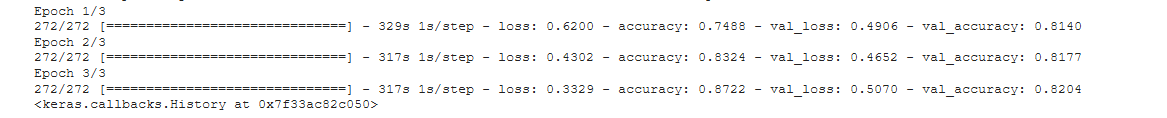